# Numerical Solution of the Abel/Hayashi "q" investment model

## [Mateo Velásquez-Giraldo](https://github.com/Mv77)

In [1]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy import optimize

In [2]:
# Class implementation

class Qmod:
    """
    A class representing the Q investment model.
    """
    
    def __init__(self,beta,tau,alpha,omega,zeta,delta):
        """
        Inputs:
        - Beta:
        - Tau:
        - Alpha:
        - Omega:
        - Zeta:
        - Delta
        """
        # Assign parameter values
        self.beta = beta
        self.tau = tau
        self.alpha = alpha
        self.omega = omega
        self.zeta = zeta
        self.delta = delta
        
        # Create empty consumption function
        self.k1Func = None
        
        # Steady state capital
        self.kss = ((1-(1-self.delta)*self.beta)/((1-self.tau)*self.alpha))**(1/(self.alpha-1))
        
    def f_k(self,k):
        return(self.alpha*k**(self.alpha-1))
    
    def j(self,i,k):
        return(k/2*((i-self.delta*k)/k)**2*self.omega)
    
    def j_i(self,i,k):
        iota = i/k - self.delta
        return(iota*self.omega)
    
    def j_k(self,i,k):
        iota = i/k - self.delta
        return(-(iota**2/2+iota*self.delta)*self.omega)
    
    # Error in the euler equation implied by a k_0, k_1, k_2 triad.
    # This can be solved to obtain the adequate triads.
    def eulerError(self,k0,k1,k2):
        
        i0 = k1 - (1-self.delta)*k0
        i1 = k2 - (1-self.delta)*k1
        error = (1+self.j_i(i0,k0)) -\
        ((1-self.tau)*self.f_k(k1) +\
         ((1-self.delta) + (1-self.delta)*self.j_i(i1,k1) - self.j_k(i1,k1))*self.beta)
        
        return(error)
    
    # Find the k_2 implied by the euler equation for an initial k_0,
    # k_1.
    def k2(self,k0,k1):
        
        sol = optimize.root_scalar(lambda x: self.eulerError(k0,k1,x), x0=k0, x1=self.kss)
        
        if sol.flag != "converged":
            raise Exception('Could not find capital value satisfying Euler equation')
        
        return(sol.root)
    
    # Find the capital trajectory implied by the euler equation for
    # an initial k_0, k_1.
    def shoot(self,k0,k1,t):
        k = np.zeros(t)
        k[0] = k0
        k[1] = k1
        for i in range(2,t):
            
            try:
                k[i] = self.k2(k[i-2],k[i-1])
            except:
                k[i:] = k[i]
                return(k)
                
            if k[i]<0 or (abs(k[i]-self.kss) > 2*abs(k0-self.kss)):
                k[i:] = k[i]
                return(k)
            
        return(k)
    
    # Shooting algorithm to find k_1 given k_0.
    def find_k1(self,k0,T=30,tol = 10**(-3),maxiter = 200):

        top = max(self.kss,k0)
        bot = min(self.kss,k0)
        
        for k in range(maxiter):
            
            init = (top+bot)/2
            path = self.shoot(k0,init,T)
    
            k_f = path[-1]
            if np.isnan(k_f):
                bot = init
            else:
                if abs(k_f - self.kss)<tol:
                    return(init)
                else:
                    if k_f >= self.kss:
                        top = init
                    else:
                        bot = init
            
        return(init)
    
    # Construction of the policy rule by solving for k_1 given
    # k_0 over a grid of points and then finding an interpolating
    # function
    def solve(self,k_min=10**(-4), n_points = 50):
        
        k_max = 4*self.kss
        k0 = np.linspace(k_min,k_max,n_points)
        k1 = np.zeros(len(k0))
        
        for i in range(len(k0)):
            
            k1[i] = self.find_k1(k0[i])
        
        self.k1Func = interpolate.interp1d(k0,k1)
    
    # Simulation of capital dynamics from a starting k_0
    def simulate(self,k0,t):
        k = np.zeros(t)
        k[0]=k0
        for i in range(1,t):
            k[i] = self.k1Func(k[i-1])
        return(k)
        
    def iota(self,lam_1):
        iota = (lam_1-1)/self.omega
        return(iota)
    
    def jkl(self,lam_1):
        iota = self.iota(lam_1)
        jk = -(iota**2/2+iota*self.delta)*self.omega
        return(jk)
        
    def dLambda(self,k,lam):
        
        bdel = self.beta*(1-self.delta)
        
        # dLambda solves the following equation:
        error = lambda x: ((1-bdel)*lam-(1-self.tau)*self.f_k(k) + self.jkl(lam+x)*self.beta)/bdel - x
        sol = optimize.root_scalar(error, bracket = [-1,1])
        
        if sol.flag != 'converged':
            return( np.float('nan') )
        else:
            return(sol.root)
    
    def dK(self,k,lam):
        iota = (lam-1)/self.omega
        return(iota*k)
    
    def plotEnvelopeCond(self,k, npoints = 10):
        
        lam_1 = np.linspace(0,2,npoints)
        prod = np.ones(npoints)*(1-self.tau)*self.f_k(k)
        iota = (lam_1-1)/self.omega
        jk = - (iota**2/2+iota*self.delta)*self.omega
        inv_gain = -jk*self.beta
        fut_val = (1-self.delta)*self.beta*lam_1
        plt.plot(lam_1,prod+inv_gain+fut_val, label = "Env. Condition value")
        plt.plot(lam_1,lam_1, linestyle = '--', color = 'k', label = "45° line")
        
        plt.legend()
        plt.title('$\\lambda (t)$ vs $\lambda (t+1)$ at $k =$ %1.2f' %(k))
        plt.xlabel('$\\lambda (t+1)$')
        plt.ylabel('$\\lambda (t)$')
        
    
    def lambda0locus(self,k):
        
        if k > self.kss:
            x1 = 0.5
        else:
            x1 = 1.5
            
        bdel = self.beta*(1-self.delta)
        
        # Lambda solves the following equation:
        error = lambda x: (1-bdel)*x - (1-self.tau)*self.f_k(k) + self.jkl(x)*self.beta
        
        sol = optimize.root_scalar(error, x0 = 1, x1 = x1)
        if sol.flag != 'converged':
            return( np.float('nan') )
        else:
            return(sol.root)
        
    def phase_diagram(self, npoints = 200):
       
        k = np.linspace(0.01*self.kss,2*self.kss,npoints)
        
        plt.figure()
        # Plot k0 locus
        plt.plot(k,1*np.ones(npoints),label = '$\\dot{k}=0$ locus')
        # Plot lambda0 locus
        plt.plot(k,[self.lambda0locus(x) for x in k],label = '$\\dot{\\lambda}=0$ locus')
        # Plot steady state
        plt.plot(self.kss,1,'*r', label = 'Steady state')
        
        # Labels
        plt.title('Phase diagram')
        plt.xlabel('K')
        plt.ylabel('Lambda')
        plt.legend()
        plt.show()

# Example

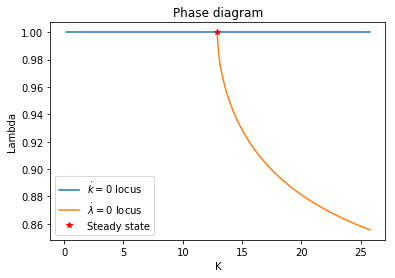

In [3]:
# Create a model object
Qexample = Qmod(beta = 0.99,tau = 0, alpha = 0.33, omega =  0.5, zeta =  0, delta = 0.05)
# Generate its phase diagram
Qexample.phase_diagram()

Why is the $\dot{\lambda}=0$ locus truncated?

With constant prices, there may be instances where $\lambda_t$ can not be equal to $\lambda_{t+1}$. Notice first that $\lambda_t$ is a function of $\lambda_{t+1}$ (current marginal value of capital is an expected function of its expected marginal value tomorrow).

If, for instance, $k_t$ is low, the marginal productivity of capital will be high, and this can push $\lambda_t$ above $\lambda_{t+1}$, as is the case in the following diagram, which plots $\lambda_t$ computed from the envelope condition at a fixed $k$ and varying $\lambda_{t+1}$.

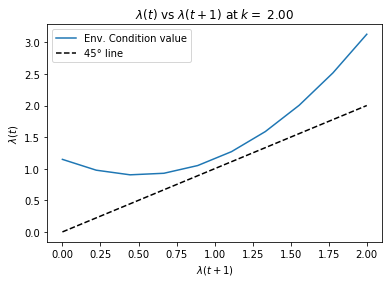

In [4]:
Qexample.plotEnvelopeCond(k=2)

Note that the envelope condition never crosses the $\lambda_t = \lambda_{t+1}$ line. Thus, there is no $\dot{\lambda}=0$ locus at $k=2$.